# Visualize chemical space

## Aim of this talktorial

This notebook explores different ways to visualize chemical space using molecular fingerprints as input, i.e., PCA, t-SNE, UMAP, TMAP. Activity data for three kinases from ChEMBL will be used as example data. The following command will create an environment named `chemical_space` that contains all needed packages:  
`conda create -n chemical_space -c conda-forge -c rdkit -c tmap rdkit tmap umap-learn matplotlib jupyterlab`

### Contents in Theory
- PCA
- t-SNE
- UMAP
- TMAP

### Contents in Practical
- Data preparation
- PCA
- t-SNE
- UMAP
- TMAP

### References
- PCA ([wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis), [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))
- t-SNE ([article](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), [wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html))
- UMAP ([article](https://arxiv.org/abs/1802.03426), [repo](https://github.com/lmcinnes/umap), [documentation](https://umap-learn.readthedocs.io/en/latest/))
- TMAP ([article](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-0416-x), [repo](https://github.com/reymond-group/tmap), [documentation](https://tmap.gdb.tools/))

## Theory

### PCA

**P**rincipal **C**omponent **A**nalysis

Principal components are the directions (vectors), in which the data shows the most variance. They are defined by Eigenvector and Eigenvalues that correspond the the direction of the variance and the intensity of the varience (Fig. 1).

![Scatter plot of a PCA](images/GaussianScatterPCA.svg)
**Fig. 1:** Example of a principal component analysis. The vectors correspond to the two Eigenvectors explaing most of the observed variance in the underlying data. The length each Eigenvector is the Eigenvalue, which corresponds to the intensity of the observed variance.

### t-SNE

**t**-distributed **S**tochastic **N**eighbor **E**mbedding

[theory](https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/)

- unlike PCA, t-SNE is not a linear projection
- t-SNE creates a probability distribution using the Gaussian distribution that defines the relationships between the points in high-dimensional space
- doesn't have the crowding problem in low-dimensional space

### UMAP

amazing examples --> [theory](https://pair-code.github.io/understanding-umap/)

- t-SNE computational expensive, problematic for bigger datasets
- similar to t-SNE but preserves the global structure better

### TMAP

## Practical

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem

from IPython.display import Image

### Data preparation

First, let's prepare data for visualization by loading the activity data and generating Morgan fingerprint with RDKit.

In [2]:
# load data
abl1 = pd.read_csv("data/chembl27_abl1_ki.csv", sep=";", quotechar='"')
abl1["target_short"] = "ABL1"
aura = pd.read_csv("data/chembl27_aura_ki.csv", sep=";", quotechar='"')
aura["target_short"] = "AURA"
cdk2 = pd.read_csv("data/chembl27_cdk2_ki.csv", sep=";", quotechar='"')
cdk2["target_short"] = "CDK2"

In [3]:
# combine data
data = pd.concat([abl1, aura, cdk2], ignore_index=True)
data.shape

(4085, 42)

In [4]:
# filter data for most active molecules
data = data[data["Standard Relation"] == "'='"]
data = data[data["Standard Units"] == "nM"]
data = data[data["Standard Value"] <= 100]
data.shape

(1074, 42)

In [5]:
# generate fingerprints
data['mol'] = data["Smiles"].apply(Chem.MolFromSmiles)
data['ecfp'] = data['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, radius=2)

In [6]:
# generate an array of fingerprints as numpy arrays
ecfp_arrays = []
for index, row in data.iterrows():
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(row['ecfp'], array)
    ecfp_arrays.append(array)
ecfp_arrays = np.asarray(ecfp_arrays)

### PCA

In [7]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(ecfp_arrays)

In [8]:
data['pca_one'] = pca_result[:,0]
data['pca_two'] = pca_result[:,1]

In [9]:
pca.explained_variance_ratio_

array([0.13106408, 0.05694998])

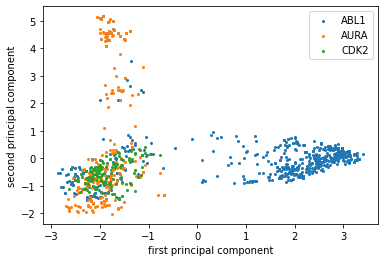

In [10]:
abl1_pca = data[data['target_short'] == "ABL1"]
aura_pca = data[data['target_short'] == "AURA"]
cdk2_pca = data[data['target_short'] == "CDK2"]
a = plt.scatter(abl1_pca['pca_one'], abl1_pca['pca_two'], 4)
b = plt.scatter(aura_pca['pca_one'], aura_pca['pca_two'], 4)
c = plt.scatter(cdk2_pca['pca_one'], cdk2_pca['pca_two'], 4)
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.legend((a, b, c), ('ABL1', 'AURA', 'CDK2'))

### t-SNE

In [11]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(ecfp_arrays)

In [12]:
data['tsne_one'] = tsne_results[:,0]
data['tsne_two'] = tsne_results[:,1]

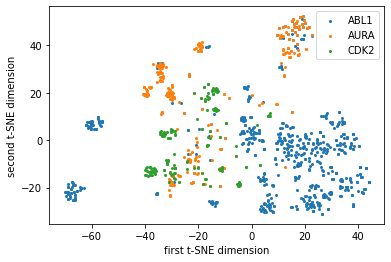

In [13]:
abl1_tsne = data[data['target_short'] == "ABL1"]
aura_tsne = data[data['target_short'] == "AURA"]
cdk2_tsne = data[data['target_short'] == "CDK2"]
a = plt.scatter(abl1_tsne['tsne_one'], abl1_tsne['tsne_two'], 4)
b = plt.scatter(aura_tsne['tsne_one'], aura_tsne['tsne_two'], 4)
c = plt.scatter(cdk2_tsne['tsne_one'], cdk2_tsne['tsne_two'], 4)
plt.xlabel("first t-SNE dimension")
plt.ylabel("second t-SNE dimension")
plt.legend((a, b, c), ('ABL1', 'AURA', 'CDK2'))

### UMAP

In [14]:
embedding = umap.UMAP().fit_transform(ecfp_arrays)
data['umap_one'] = embedding.T[0]
data['umap_two'] = embedding.T[1]

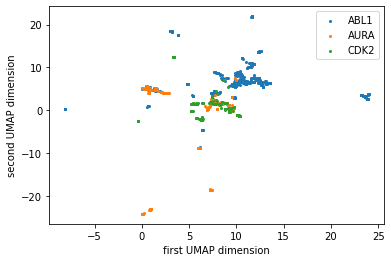

In [15]:
abl1_umap = data[data['target_short'] == "ABL1"]
aura_umap = data[data['target_short'] == "AURA"]
cdk2_umap = data[data['target_short'] == "CDK2"]
a = plt.scatter(abl1_umap['umap_one'], abl1_umap['umap_two'], 4)
b = plt.scatter(aura_umap['umap_one'], aura_umap['umap_two'], 4)
c = plt.scatter(cdk2_umap['umap_one'], cdk2_umap['umap_two'], 4)
plt.xlabel("first UMAP dimension")
plt.ylabel("second UMAP dimension")
plt.legend((a, b, c), ('ABL1', 'AURA', 'CDK2'))

## TMAP

In [16]:
Image(url="https://tmap.gdb.tools/src/npatlas/npatlas.jpg")